Homework 4: LTSM
Darren Liu dl499
November 17, 2023
SYSEN 6888

In [ ]:
from music21 import converter, instrument, note, chord, stream
import tensorflow, numpy
!pip install pretty_midi

In [ ]:
#generating the input data from MIDI files

def generate_input_data(song_path):

    notes = []
    midi = converter.parse(song_path)
    print("Parsing %s" % song_path)

    # use flat notes only
    notes_to_parse = midi.flat.notes

    for element in notes_to_parse:
        if isinstance(element, note.Note):
            notes.append(str(element.pitch))
        elif isinstance(element, chord.Chord):
            notes.append('.'.join(str(n) for n in element.normalOrder))

    sequence_length = 100

    # get all pitch names
    pitchnames = sorted(set(item for item in notes))

     # create a dictionary to map pitches to integers
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    network_input = []
    network_output = []

    # create input sequences and the corresponding outputs
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])
        network_output.append(note_to_int[sequence_out])

    n_patterns = len(network_input)

    # reshape the input into a format compatible with LSTM layers
    network_input = numpy.reshape(network_input, (n_patterns, sequence_length, 1))
    # normalize input
    n_vocab = len(set(notes))
    network_input = network_input / float(n_vocab)

    network_output = tensorflow.keras.utils.to_categorical(network_output)

    return network_input, network_output, pitchnames, n_vocab


In [ ]:
#Generate new sequence of notes from a given sequence

def generate_sequence(model, network_input, pitchnames, n_vocab, length=500):
    # Select a random sequence from the input as a starting point for the prediction
    start_index = np.random.randint(0, len(network_input) - 1)

    int_to_note = dict((number, note) for number, note in enumerate(pitchnames))

    # Get the initial pattern
    pattern = network_input[start_index]

    prediction_output = []

    # Generate 500 notes
    for note_index in range(length):
        prediction_input = np.reshape(pattern, (1, len(pattern), 1))
        prediction_input = prediction_input / float(n_vocab)

        prediction = model.predict(prediction_input, verbose=0)

        index = np.argmax(prediction)
        result = int_to_note[index]
        prediction_output.append(result)

        pattern = np.append(pattern, index)
        pattern = pattern[1:len(pattern)]

    return prediction_output


In [ ]:
#Create MIDI file from the generated sequence

def create_midi(prediction_output):
    """ convert the output from the prediction to notes and create a midi file
        from the notes """
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 0.5

    midi_stream = stream.Stream(output_notes)

    midi_stream.write('midi', fp='very_sad_moshart.mid')

Building the Neural Network to generate music using the generated music composition from the initial mozart.mid file


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import pretty_midi
from music21 import converter, instrument, note, chord, stream
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#mounting file path to the network model
song_path = "/content/drive/MyDrive/Colab Notebooks/datasets/mozart.mid"
network_input, network_output, pitchnames, n_vocab = generate_input_data(song_path)

Parsing /content/drive/MyDrive/Colab Notebooks/datasets/mozart.mid


/usr/local/lib/python3.10/dist-packages/music21/stream/base.py:3694: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


In [ ]:
#LSTM model sequentially layered structure, 1 input tensor 1 output tensor

model = Sequential([
    LSTM(512, input_shape=(network_input.shape[1], network_input.shape[2]),
         recurrent_dropout=0.3, return_sequences=True),
    LSTM(512, recurrent_dropout=0.3),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(n_vocab, activation='softmax')
])

In [ ]:
#compiling model with ADAM optimizer with categorical cross-entropy loss (softmax loss)

from tensorflow.keras.optimizers import Adam

# Define your custom learning rate
custom_learning_rate = 0.001

# Create an Adam optimizer with the custom learning rate
adam_custom = Adam(learning_rate=custom_learning_rate)

# Compile the model with the custom optimizer
model.compile(optimizer=adam_custom, loss='categorical_crossentropy')

In [ ]:
# Fit the model to the data
history = model.fit(network_input, network_output, epochs=200, batch_size=512)

Epoch 1/200
5/5 [==============================] - 8s 507ms/step - loss: 3.5739
Epoch 2/200
5/5 [==============================] - 2s 494ms/step - loss: 2.8556
Epoch 3/200
5/5 [==============================] - 2s 489ms/step - loss: 2.2440
Epoch 4/200
5/5 [==============================] - 2s 472ms/step - loss: 1.9315
Epoch 5/200
5/5 [==============================] - 2s 491ms/step - loss: 1.6485
Epoch 6/200
5/5 [==============================] - 2s 467ms/step - loss: 1.5249
Epoch 7/200
5/5 [==============================] - 2s 481ms/step - loss: 1.4428
Epoch 8/200
5/5 [==============================] - 2s 486ms/step - loss: 1.3703
Epoch 9/200
5/5 [==============================] - 2s 479ms/step - loss: 1.3088
Epoch 10/200
5/5 [==============================] - 2s 482ms/step - loss: 1.2798
Epoch 11/200
5/5 [==============================] - 2s 481ms/step - loss: 1.2533
Epoch 12/200
5/5 [==============================] - 2s 482ms/step - loss: 1.2490
Epoch 13/200
5/5 [===================

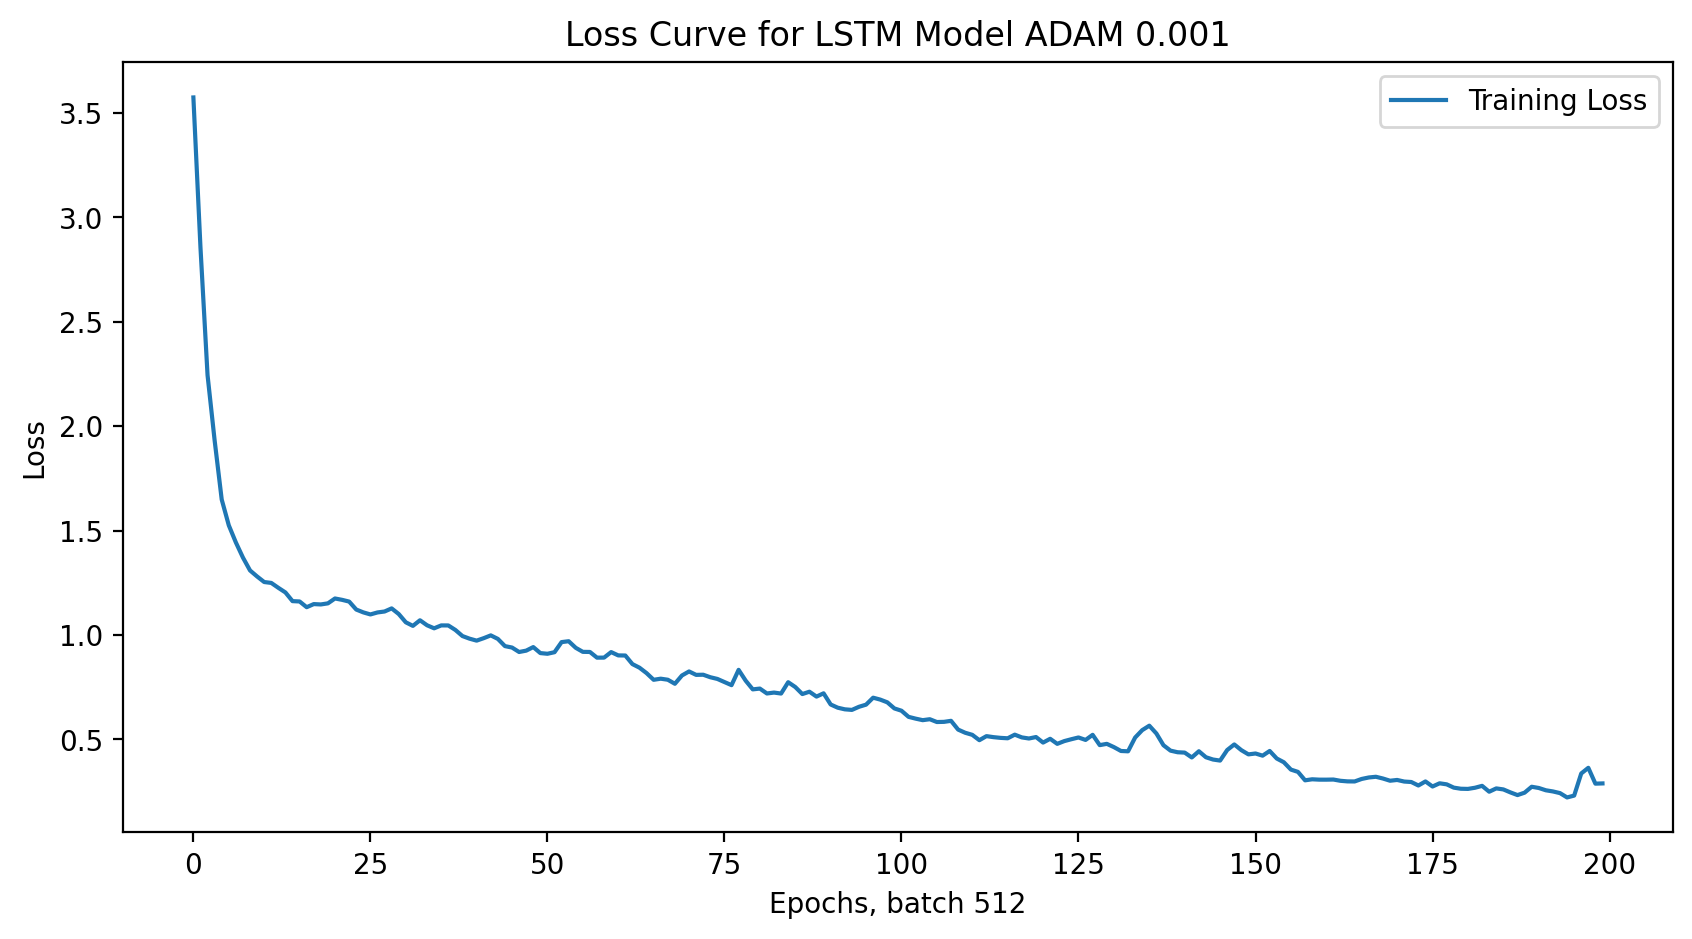

In [ ]:
#plotting loss curves for LSTM model
import matplotlib.pyplot as plt

# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Loss Curve for LSTM Model ADAM 0.001')
plt.xlabel('Epochs, batch 512')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Generate a new sequence of notes
prediction_output = generate_sequence(model, network_input, pitchnames, n_vocab)

In [ ]:
# Create a MIDI file from the generated sequence
create_midi(prediction_output)

In [ ]:
!kill -9 -1